<a href="https://colab.research.google.com/github/SergJohn/Crypto-Prediction-2022-Project/blob/main/ExpoSmoth_Creating_Function_Automation_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
**Holtwinters**
First attempt - as the data does not have trend or seasonality, it is not performing well
---

In [ ]:
 # Load the libraries
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES

import warnings
warnings.filterwarnings('ignore') # We can suppress the warnings

In [ ]:
# Read the data set into a Pandas data frame. Note that the Date column (column 0) is the index column and it has 
# the format mm-dd-yyyy.
df = pd.read_csv('BTC-USD.csv', index_col = [0])
#df = pd.read_csv('BTC-USD.csv')

# By default, date columns are represented as object when loading data from a CSV file. To read the date column correctly, 
# we can use the argument parse_dates to specify a list of date columns.

df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-10-16,394.518005,398.807007,373.070007,382.556000,382.556000,26990000
2014-10-17,382.756012,385.477997,375.389008,383.757996,383.757996,13600700
2014-10-18,383.976013,395.157990,378.971008,391.441986,391.441986,11416800
2014-10-19,391.253998,393.938995,386.457001,389.545990,389.545990,5914570
2014-10-20,389.230988,390.084015,378.252014,382.845001,382.845001,16419000


In [ ]:
df.drop(['High', 'Low', 'Open', 'Volume', 'Adj Close'], axis=1, inplace=True)

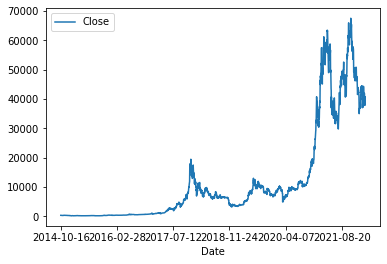

In [ ]:
# Plot the data:
df.plot()

# Show the plot
plt.show()

In [ ]:
# get data from dataset from July 2020
start_date = '2020-07-16'
end_date = '2022-02-02'
mask = (df['Date'] > start_date) & (df['Date'] <= end_date)
df = df.loc[mask] 

In [ ]:
# Important step to make the model work - Set the Date column as Index
#df["Date"] = pd.to_datetime(df["Date"])
df.set_index('Date', inplace=True)
df.index = pd.PeriodIndex(df.index, freq="D")
df.head()

In [ ]:
# Split between the training and the test data sets. The last 12 periods form the test data.
df_train = df.iloc[:-12]    # Remove last 12 rows
df_test = df.iloc[-12:]     # Consider only last 12 rows

# Display the size of the dataframes
df_train.shape, df_test.shape

((2697, 1), (12, 1))

In [ ]:
# Build and train the model on the training data. In the above chart, the level of the time series seems to be 
# increasing linearly. So we set the trend as additive. However, the seasonal variation around each level seems to be 
# increasing in proportion to the current level. So we set the seasonality to multiplicative.
model = HWES(df_train, seasonal_periods = 12, trend = 'add', seasonal = 'mul')

# Train the model
fitted = model.fit()

In [ ]:
# Print out the training summary.
print(fitted.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                 2697
Model:             ExponentialSmoothing   SSE                     1866673421.068
Optimized:                         True   AIC                          36299.984
Trend:                         Additive   BIC                          36394.383
Seasonal:                Multiplicative   AICC                         36300.240
Seasonal Periods:                    12   Date:                 Wed, 06 Apr 2022
Box-Cox:                          False   Time:                         14:32:22
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.7894737                alpha                 True
smoothing_slope          

In [ ]:
# Create an out of sample forecast for the next 12 steps beyond the final data point in the training data set.
Pricing_forecast = fitted.forecast(steps = 12)

In [ ]:
df_train.shape, df_test.shape, Pricing_forecast.shape

((2697, 1), (12, 1), (12,))

In [ ]:
df_train[316:328].shape, df_test.shape, Pricing_forecast.shape

((12, 1), (12, 1), (12,))

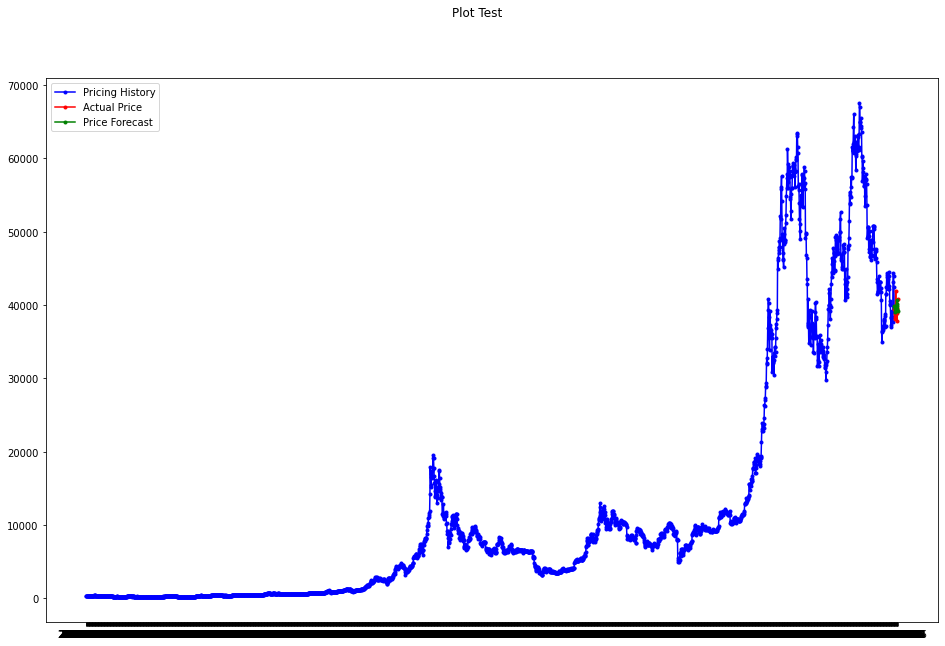

In [ ]:
# Plot the training data, the test data and the forecast on the same plot.
fig = plt.figure(figsize = (16, 10))
fig.suptitle('Plot Test')
past, = plt.plot(df_train.index, df_train, 'b.-', label = 'Pricing History')
future, = plt.plot(df_test.index, df_test, 'r.-', label = 'Actual Price')
predicted_future, = plt.plot(df_test.index, Pricing_forecast, 'g.-', label = 'Price Forecast')
plt.legend(handles = [past, future, predicted_future])
plt.show()

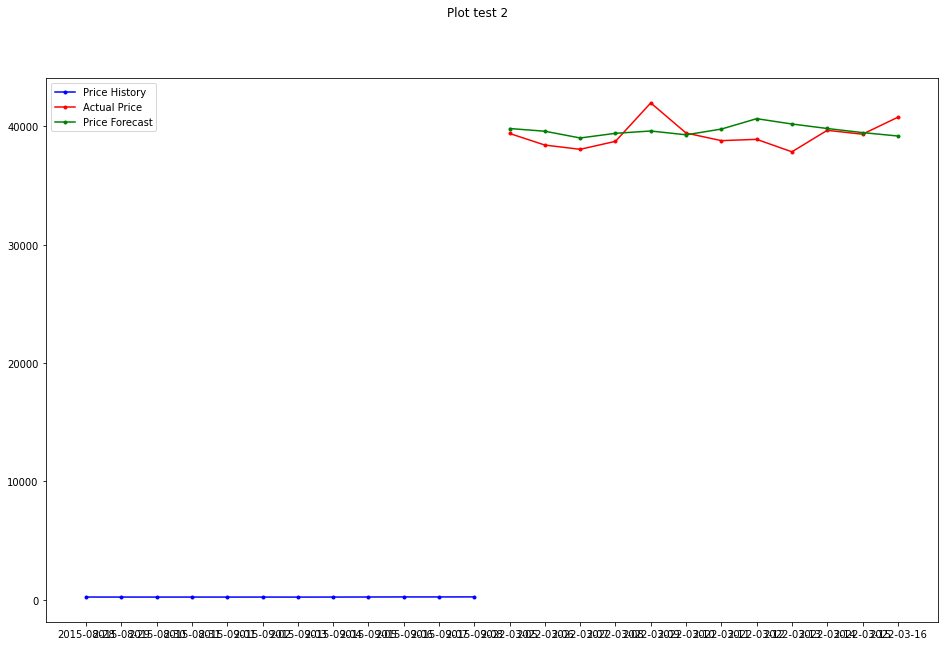

In [ ]:
# Plot the training data, the test data and the forecast on the same plot.
fig = plt.figure(figsize = (16, 10))
fig.suptitle('Plot test 2')
past, = plt.plot(df_train[316:328].index, df_train[316:328], 'b.-', label = 'Price History')
future, = plt.plot(df_test.index, df_test, 'r.-', label = 'Actual Price')
predicted_future, = plt.plot(df_test.index, Pricing_forecast, 'g.-', label = 'Price Forecast')
plt.legend(handles = [past, future, predicted_future])
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print(f'Mean Absolute Error = {mean_absolute_error(df_test, Pricing_forecast)}')
print(f'Mean Squared Error = {mean_squared_error(df_test, Pricing_forecast)}')
print(f'r^2 score = {r2_score(df_test, Pricing_forecast)}')

Mean Absolute Error = 1057.8881659729461
Mean Squared Error = 1721340.5926209453
r^2 score = -0.4091849040951363


The holt's approach did not gave good results due to the lack of trending and seasonality... let's try another approach.

---
**Trying Simple Exponential Smoothing**
---

In [53]:
# Load all related libraries
#import esFunctions as es
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import axes

import warnings
warnings.filterwarnings('ignore') # We can suppress the warnings

In [148]:
# Function code to perform single or simple exponential smoothing
def single_exp_smoothing(x, alpha):
    F = [x[0]]                                  # first value is same as series
    for t in range(1, len(x)):                  # for loop for all values stored in x
        F.append(alpha * x[t] + (1 - alpha) * F[t - 1])
        if x[t] == np.NaN:
          x[t] = F[t - 1]
          F.append(alpha * x[t] + (1 - alpha) * F[t - 1])
    return F

In [163]:
# Load the data file
df = pd.read_csv('BTC-USD.csv')

# Display the first five records
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-10-16,394.518005,398.807007,373.070007,382.556000,382.556000,26990000
1,2014-10-17,382.756012,385.477997,375.389008,383.757996,383.757996,13600700
2,2014-10-18,383.976013,395.157990,378.971008,391.441986,391.441986,11416800
3,2014-10-19,391.253998,393.938995,386.457001,389.545990,389.545990,5914570
4,2014-10-20,389.230988,390.084015,378.252014,382.845001,382.845001,16419000


In [164]:
df['Date'].tail(1)

2708    2022-03-16
Name: Date, dtype: object

In [165]:
test_close_last = df['Close'].tail(1)
print(test_close_last)

2708    40769.9375
Name: Close, dtype: float64


In [166]:
df.drop(['High', 'Low', 'Open', 'Volume', 'Adj Close'], axis=1, inplace=True)

In [167]:
df.head(3)

,Date,Close
0,2014-10-16,382.556000
1,2014-10-17,383.757996
2,2014-10-18,391.441986


In [168]:
# Add a new column (SES) in the dataframe
#df['SES'] = es.single_exp_smoothing(df['Close'], 0.8)
df['SES'] = single_exp_smoothing(df['Close'], 0.8)

# Display first five records
df.head()

,Date,Close,SES
0,2014-10-16,382.556000,382.556000
1,2014-10-17,383.757996,383.517597
2,2014-10-18,391.441986,389.857108
3,2014-10-19,389.545990,389.608214
4,2014-10-20,382.845001,384.197644


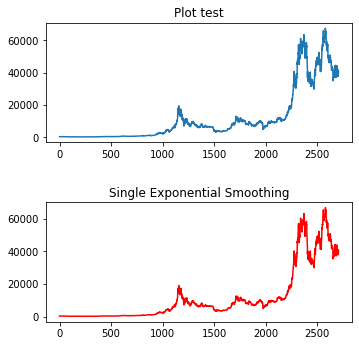

In [169]:
# plot the above dataframe
fig = plt.figure(figsize = (5.5, 5.5))
ax = fig.add_subplot(2, 1, 1)
fig.subplots_adjust(hspace = 0.5)
df['Close'].plot(ax = ax)
ax.set_title('Plot test')
ax = fig.add_subplot(2, 1, 2)
df['SES'].plot(ax = ax, color = 'r')
ax.set_title('Single Exponential Smoothing')

# Save the png file on your folder
plt.savefig('_02_1.png', format = 'png', dpi = 300)

In [170]:
# Comapre Single exponential smooting for three values of alpha (0.2, 0.6, 0.8)
#df['SES2'] = es.single_exp_smoothing(df['Close'], 0.2)
#df['SES6'] = es.single_exp_smoothing(df['Close'], 0.6)
#df['SES8'] = es.single_exp_smoothing(df['Close'], 0.8)

# Comapre Single exponential smooting for three values of alpha (0.2, 0.6, 0.8)
df['SES2'] = single_exp_smoothing(df['Close'], 0.2)
df['SES6'] = single_exp_smoothing(df['Close'], 0.6)
df['SES8'] = single_exp_smoothing(df['Close'], 0.8)

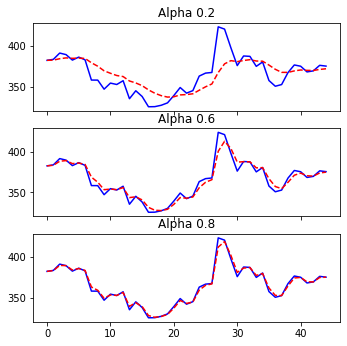

In [171]:
# plot three figures for three values of alpha
f, axarr = plt.subplots(3, sharex = True)
f.set_size_inches(5.5, 5.5)

df['Close'].iloc[:45].plot(color='b', linestyle = '-', ax=axarr[0])
df['SES2'].iloc[:45].plot(color='r', linestyle = '--', ax=axarr[0])
axarr[0].set_title('Alpha 0.2')

df['Close'].iloc[:45].plot(color='b', linestyle = '-', ax=axarr[1])
df['SES6'].iloc[:45].plot(color='r', linestyle = '--', ax=axarr[1])
axarr[1].set_title('Alpha 0.6')

df['Close'].iloc[:45].plot(color='b', linestyle = '-', ax=axarr[2])
df['SES8'].iloc[:45].plot(color='r', linestyle = '--', ax=axarr[2])
axarr[2].set_title('Alpha 0.8')
plt.savefig('_02_02.png', format='png', dpi=300)

In [172]:
Pricing_forecast = df['SES8'].iloc[:45]
df_test = df['Close'].iloc[:45]

In [173]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print(f'Mean Absolute Error = {mean_absolute_error(df_test, Pricing_forecast)}')
print(f'Mean Squared Error = {mean_squared_error(df_test, Pricing_forecast)}')
print(f'r^2 score = {r2_score(df_test, Pricing_forecast)}')

Mean Absolute Error = 1.7462065456312037
Mean Squared Error = 7.098476386034409
r^2 score = 0.9862466206951394


In [174]:
df.tail()

,Date,Close,SES,SES2,SES6,SES8
2704,2022-03-12,38904.011719,38922.894667,39557.202784,39039.989539,38922.894667
2705,2022-03-13,37849.664063,38064.310184,39215.695040,38325.794254,38064.310184
2706,2022-03-14,39666.753906,39346.265162,39305.906813,39130.370045,39346.265162
2707,2022-03-15,39338.785156,39340.281157,39312.482482,39255.419112,39340.281157
2708,2022-03-16,40769.937500,40484.006231,39603.973485,40164.130145,40484.006231


In [ ]:
pip install sktime

In [175]:
from sktime.utils.plotting import plot_series

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68ef7bfc90>)

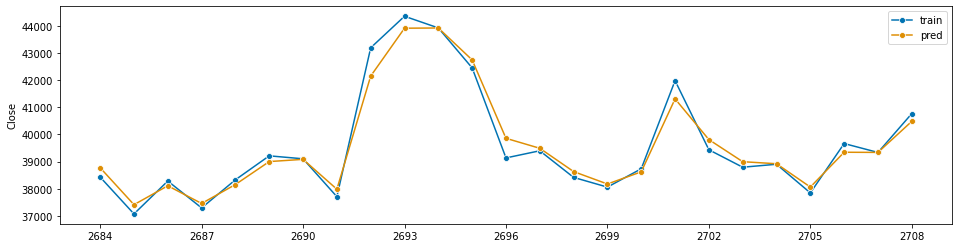

In [176]:
plot_series(df['Close'].iloc[-25:], df['SES8'].iloc[-25:], labels = ["train", "pred"])

In [177]:
x = df['SES8'].tail(1)
print(x)

2708    40484.006231
Name: SES8, dtype: float64


---
Let's check the accuracy when using 0.2 of Alfa

In [ ]:
Pricing_forecast = df['SES2'].iloc[:45]
df_test = df['Close'].iloc[:45]

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print(f'Mean Absolute Error = {mean_absolute_error(df_test, Pricing_forecast)}')
print(f'Mean Squared Error = {mean_squared_error(df_test, Pricing_forecast)}')
print(f'r^2 score = {r2_score(df_test, Pricing_forecast)}')

Mean Absolute Error = 10.748052052139379
Mean Squared Error = 233.8338765685811
r^2 score = 0.5469441857831823


---
Clearly 0.8 Alfa gives a better accuracy on the Model

---
**Now making the initial idea gets form**
---
Make a HTTP request to an external API, getting the real time of the crypto and apply to a formula to give a sort of 'intention' to the user, afterwards

In [188]:
import requests


In [189]:
real_time_price = requests.get('https://bitpay.com/api/rates/USD')
print(real_time_price.status_code)

200


In [190]:
print(real_time_price.content)

b'{"code":"USD","name":"US Dollar","rate":39164.9}'


In [191]:
print(real_time_price.json())

{'code': 'USD', 'name': 'US Dollar', 'rate': 39164.9}


In [192]:
x = real_time_price.json()

In [193]:
print(x)

{'code': 'USD', 'name': 'US Dollar', 'rate': 39164.9}


In [194]:
print(x['rate'])

39164.9


put all the code from the API call in one function

In [195]:
def find_real_time_value():
  real_time_price = requests.get('https://bitpay.com/api/rates/USD')
  #print(real_time_price.status_code)
  #print(real_time_price.content)
  #print(real_time_price.json())
  x = real_time_price.json()
  #print(x)
  #print(x['rate'])
  return x['rate']

find_real_time_value()

39169.44

In [196]:
test = find_real_time_value()
print(test)

39164.9


In [197]:
if test > test_close_last.item():
  print('real time is bigger')
else:
  print('the closing time is bigger')

the closing time is bigger


---
Tests are working as expected...


Next step: Create a function, based on business ideas, investiments facts, or even in statistical point of view and we can find time to check this out. 

Example: 


1.   When the amount is increasing 1000 more, sell it to generate profit and prevent losses
2.   When it falls  2/3 of the profit, sells to prevent losses
3.   When it is 1/3 below the average, buys to generate profit when it goes up
4.   When it reaches a limit similar of when the cryptos die, do not buy. or another example, do not buy if it is below 2/3 of the average.



Decide through the function a few rules, such as:
*  hold
*  sell
*  buy